In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [12]:
btc = pd.read_csv("../data/Bitstamp_BTCUSD_1h.csv", skiprows=1, index_col="date", parse_dates=True)
btc.sort_index(inplace=True)

<Axes: xlabel='date'>

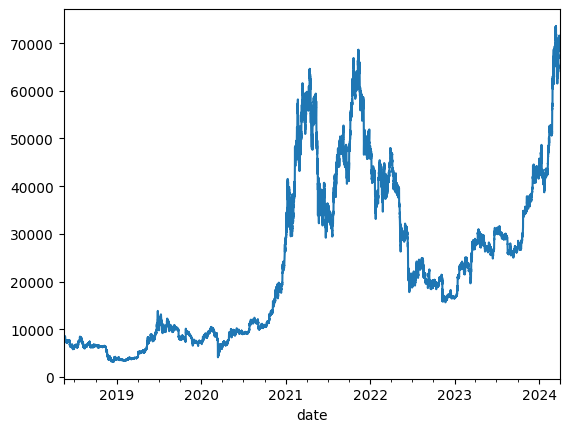

In [13]:
btc["close"].plot()

In [14]:
train = btc.iloc[btc.index.year <= 2021, 2:]
test = btc.iloc[btc.index.year == 2022, 2:]

In [15]:
train_X, train_y = train.drop(columns=['close']), train.close.values
test_X, test_y = test.drop(columns=['close']), test.close.values

In [16]:
mm = MinMaxScaler()
ss = StandardScaler()

In [17]:
X_trans = ss.fit_transform(train_X)
y_trans = mm.fit_transform(train_y.reshape(-1, 1))

In [18]:
X_test = ss.transform(test_X)
y_test = mm.transform(test_y.reshape(-1, 1))

In [19]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [20]:
X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 6)
X_test, y_test = split_sequences(X_test, y_test, 100, 6)

In [21]:
X_train_tensors = torch.Tensor(X_ss)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_mm)
y_test_tensors = torch.Tensor(y_test)

In [22]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([31738, 100, 5]) torch.Size([31738, 6])
Testing Shape: torch.Size([8656, 100, 5]) torch.Size([8656, 6])


In [23]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [24]:
def training_loop(n_epochs, lstm, opt, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        opt.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        opt.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [25]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 10000 # 1000 epochs
learning_rate = 0.0001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 6 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [26]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
opt = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [27]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              opt=opt,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.13787, test loss: 0.14546
Epoch: 100, train loss: 0.06607, test loss: 0.06895
Epoch: 200, train loss: 0.03333, test loss: 0.04096
Epoch: 300, train loss: 0.01626, test loss: 0.02906
Epoch: 400, train loss: 0.00821, test loss: 0.02475
Epoch: 500, train loss: 0.00484, test loss: 0.02341
Epoch: 600, train loss: 0.00350, test loss: 0.02282
Epoch: 700, train loss: 0.00301, test loss: 0.02244
Epoch: 800, train loss: 0.00281, test loss: 0.02209
Epoch: 900, train loss: 0.00269, test loss: 0.02169
Epoch: 1000, train loss: 0.00259, test loss: 0.02127
Epoch: 1100, train loss: 0.00251, test loss: 0.02084
Epoch: 1200, train loss: 0.00244, test loss: 0.02042
Epoch: 1300, train loss: 0.00237, test loss: 0.02001
Epoch: 1400, train loss: 0.00230, test loss: 0.01962
Epoch: 1500, train loss: 0.00223, test loss: 0.01925
Epoch: 1600, train loss: 0.00214, test loss: 0.01891
Epoch: 1700, train loss: 0.00207, test loss: 0.01847
Epoch: 1800, train loss: 0.00201, test loss: 0.01804
Epoch

In [60]:
test_predict = lstm(X_test_tensors_final)

In [61]:
test_predict = mm.inverse_transform(test_predict.detach().numpy())

test_target = y_test_tensors.detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target)

In [90]:
pred = pd.DataFrame(test_predict)
actual = pd.DataFrame(test_target)

In [102]:
pred["buy"] = np.where(pred[5] > pred[0], 1, 0)
pred["sell"] = np.where(actual[3] > actual[0], 1, 0)

In [92]:
from sklearn.metrics import mean_squared_error

In [94]:
for col in pred.columns:
    print(col, mean_squared_error(actual[col], pred[col]))

0 70923.95
1 138008.25
2 150885.38
3 210424.34
4 254460.28
5 303017.97


<Axes: >

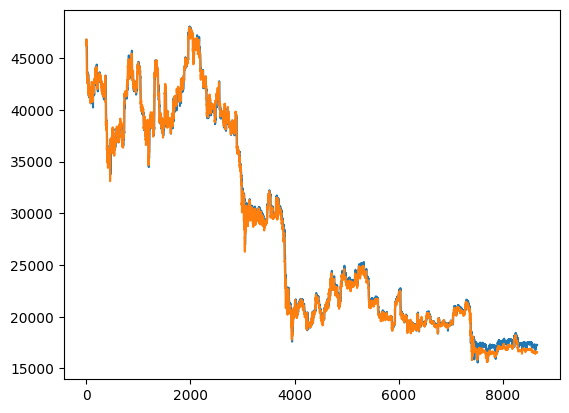

In [108]:
pred[5].plot()
actual[5].plot()

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [98]:
cm = confusion_matrix(pred["buy"],pred["sell"])

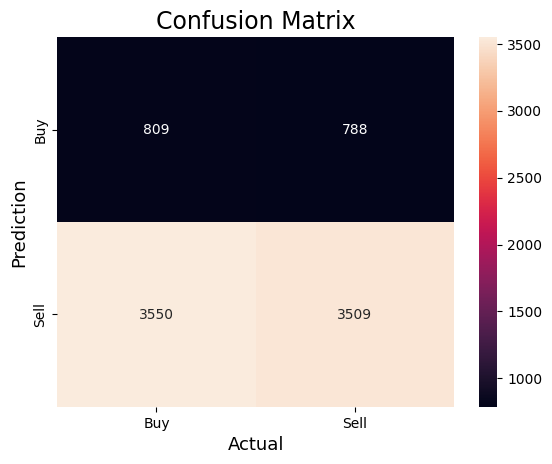

In [99]:
cm = confusion_matrix(pred["buy"],pred["sell"])
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Buy','Sell'],
            yticklabels=['Buy','Sell'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [89]:
valid = btc.iloc[btc.index.year > 2022, 2:]
valid_X, valid_y = valid.drop(columns=['close']), test.close.values

In [76]:
model_scripted = torch.jit.script(lstm) # Export to TorchScript
model_scripted.save('model_scripted.pt') #

<Axes: >

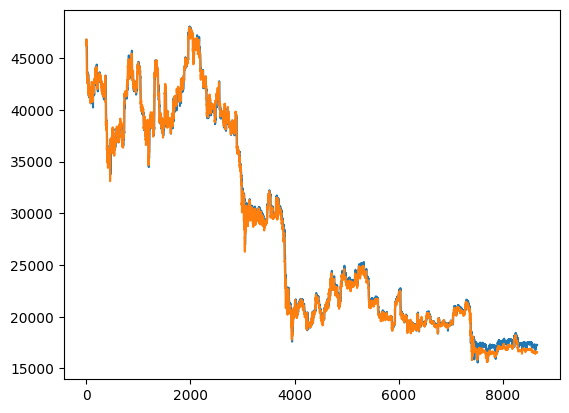

In [74]:
pd.DataFrame(test_predict)[5].plot()
pd.DataFrame(test_target)[5].plot()

In [67]:
test_target = y_test_tensors.detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target)

In [68]:
pd.DataFrame(test_target)

,0,1,2,3,4,5
0,46444.492188,46421.968750,46311.871094,46459.410156,46404.742188,46414.222656
1,46421.968750,46311.871094,46459.410156,46404.742188,46414.222656,46414.222656
2,46311.871094,46459.410156,46404.742188,46414.222656,46414.222656,46827.000000
3,46459.410156,46404.742188,46414.222656,46414.222656,46827.000000,46288.542969
4,46404.742188,46414.222656,46414.222656,46827.000000,46288.542969,46201.089844
...,...,...,...,...,...,...
8651,16584.000000,16584.000000,16594.000000,16571.000000,16567.000000,16561.000000
8652,16584.000000,16594.000000,16571.000000,16567.000000,16561.000000,16559.000000
8653,16594.000000,16571.000000,16567.000000,16561.000000,16559.000000,16543.000000
8654,16571.000000,16567.000000,16561.000000,16559.000000,16543.000000,16508.000000


In [46]:
pd.DataFrame(y_test_tensors.detach().numpy())

,0,1,2,3,4,5
0,0.661270,0.660926,0.659245,0.661497,0.660663,0.660807
1,0.660926,0.659245,0.661497,0.660663,0.660807,0.660807
2,0.659245,0.661497,0.660663,0.660807,0.660807,0.667111
3,0.661497,0.660663,0.660807,0.660807,0.667111,0.658888
4,0.660663,0.660807,0.660807,0.667111,0.658888,0.657553
...,...,...,...,...,...,...
8651,0.205296,0.205296,0.205448,0.205097,0.205036,0.204944
8652,0.205296,0.205448,0.205097,0.205036,0.204944,0.204914
8653,0.205448,0.205097,0.205036,0.204944,0.204914,0.204669
8654,0.205097,0.205036,0.204944,0.204914,0.204669,0.204135


In [49]:
test

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2022-01-01 00:00:00,46230.00,46737.06,46199.90,46650.66,43.922784,2.049027e+06
2022-01-01 01:00:00,46656.08,46921.30,46560.83,46773.08,39.847428,1.863787e+06
2022-01-01 02:00:00,46768.85,46928.90,46719.22,46808.10,40.094996,1.876771e+06
2022-01-01 03:00:00,46818.05,46904.54,46768.80,46814.16,15.294509,7.159996e+05
2022-01-01 04:00:00,46814.16,46877.85,46562.27,46706.13,85.277530,3.982983e+06
...,...,...,...,...,...,...
2022-12-31 19:00:00,16567.00,16571.00,16560.00,16561.00,16.988761,2.813509e+05
2022-12-31 20:00:00,16561.00,16562.00,16558.00,16559.00,5.583060,9.244989e+04
2022-12-31 21:00:00,16559.00,16559.00,16542.00,16543.00,15.973533,2.642502e+05


In [31]:
X_test_tensors_final.shape

torch.Size([8656, 100, 5])

In [29]:
test_predict.detach().numpy()

array([[0.2144974 , 0.2139984 , 0.21496496, 0.21547742, 0.21556549,
        0.2158331 ]], dtype=float32)

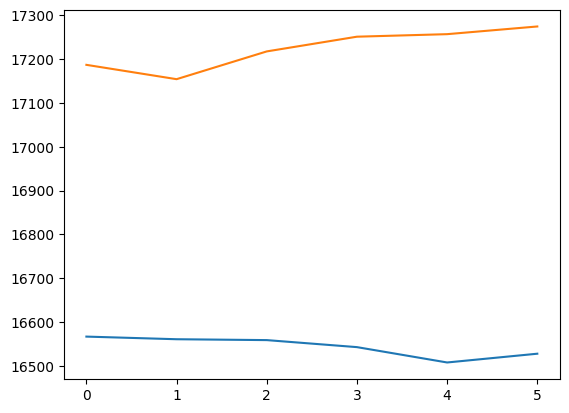

In [30]:
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")

In [ ]:
y_test_tensors[-1].detach().numpy()

In [ ]:
test_predict.detach().numpy()